# Overview

This example notebook will demonstrate Howso Engine’s ability to use case MDA to identify centroids in the data, then use the influential cases of each centroid to conduct matching of the data. 

Definitions:
 
    - case_mda: mean decrease in accuracy for the local model as if each individual case were not in the model 

    - influential_cases: returns the most influential cases and their influence weights based on generalized distances as probability mass 

Note: case_mda is available for "targeted" workflow only, influential_cases are available for both "targeted" and "targetless" workflows. 

In [1]:
from pprint import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import boxcox, inv_boxcox
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, pairwise_distances

from howso import engine
from howso.utilities import infer_feature_attributes

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Generate a simple dataset

For this example, we will create a simple data set which consists of three features. 


In [2]:
# Generate simple data set with three features
blobs = make_blobs(n_samples=1000, n_features=3, centers=50, random_state=0)
df = pd.DataFrame(blobs[0], columns=['x', 'y', 'price'])

#Rescale price feature such that it is always positive
df['price'] = df['price'] + abs(df['price'].min()) + 1

# # (Optional) Inverse Box-Cox transform to create a Pareto-like distribution
# df['x'] = inv_boxcox(df['x'], .5)
# df['price'] = inv_boxcox(df['price'], .25)

# Store the target cluster for demonstration evaluation
target = blobs[1]
df.shape

(1000, 3)

Visualization of the dataset to show the clusters. Note, the plot below is only showing two dimensions.

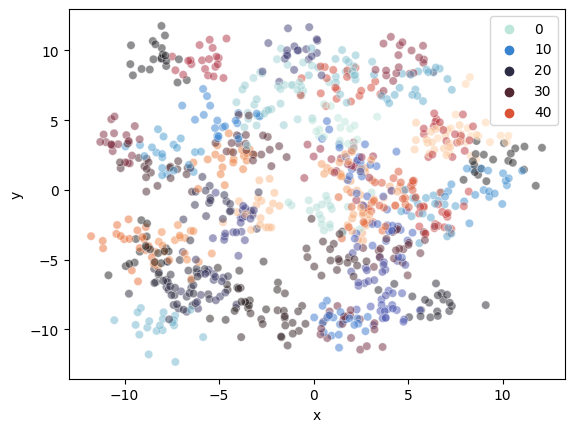

In [3]:
ax = sns.scatterplot(data = df, x='x', y='y', hue=target, palette=sns.color_palette("icefire", as_cmap=True), alpha=0.5)
plt.show()

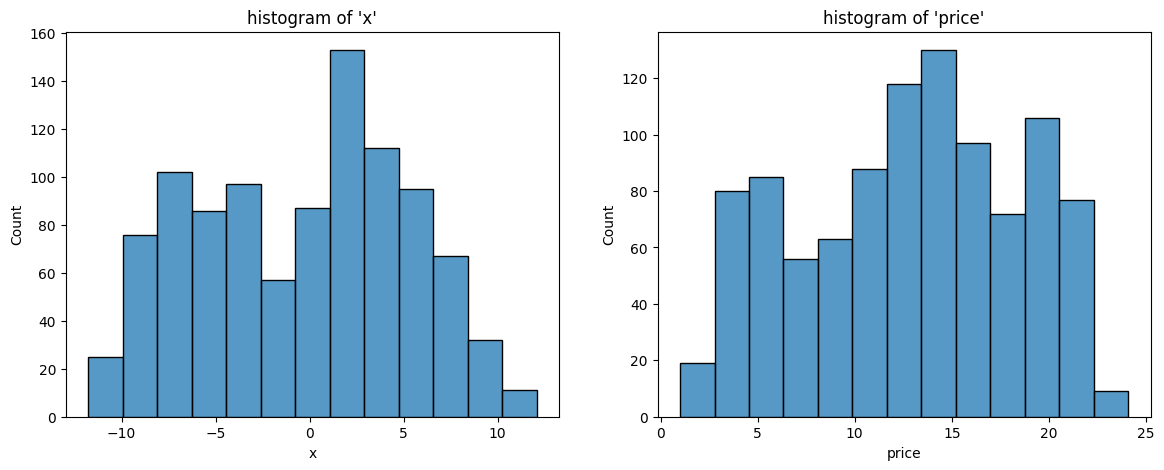

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.histplot(df['x'], ax=ax[0]).set_title("histogram of 'x'")
sns.histplot(df['price'], ax=ax[1]).set_title("histogram of 'price'")
plt.show()

# Build Howso Engine model

In this section, we will build and analyze the Howso Engine model.

In [5]:
# Identify feature types
features = infer_feature_attributes(df)

# Instantiate and train the model 
t = engine.Trainee(name="Engine - Fuzzy Matching Recipe",  features=features, overwrite_existing=True)
t.train(cases=df)

# Specify the context (independent variable) and action (target) feature
context_features = features.get_names(without=['price'])
action_features = 'price'

# Analyze the model
t.analyze(context_features=context_features, action_features=[action_features])

# Store the session ID to retrieve training cases for later evaluation
sessions = t.get_sessions()
session_id = sessions[0]['id']
session_id

'd57a8cd2-a418-47cc-98f5-9b7ce2741cd0'

In [6]:
# Feature types
pprint(features)

{'price': {'bounds': {'max': 54.598150033144236, 'min': 1.0},
           'decimal_places': 16,
           'original_type': {'data_type': 'numeric', 'size': 8},
           'type': 'continuous'},
 'x': {'bounds': {'max': 20.085536923187668, 'min': -20.085536923187668},
       'decimal_places': 19,
       'original_type': {'data_type': 'numeric', 'size': 8},
       'type': 'continuous'},
 'y': {'bounds': {'max': 20.085536923187668, 'min': -20.085536923187668},
       'decimal_places': 18,
       'original_type': {'data_type': 'numeric', 'size': 8},
       'type': 'continuous'}}


In [7]:
# Hyperparameters for the model
pprint(t.get_params())

{'analyze_growth_factor': 7.389056,
 'analyze_threshold': 100,
 'auto_analyze': False,
 'auto_analyze_limit_size': 200000,
 'default_hyperparameter_map': {'allFeatureResidualsCached': False,
                                'dt': -1,
                                'featureDeviations': None,
                                'featureDomainAttributes': {'price': 53.598150033144236,
                                                            'x': 40.171073846375336,
                                                            'y': 40.171073846375336},
                                'featureWeights': None,
                                'k': 8,
                                'p': 0.1,
                                'paramPath': ['.default'],
                                'useDeviations': False},
 'hyperparameter_map': {'price': {'x.y.': {'full': {'.none': {'allFeatureResidualsCached': False,
                                                              'dt': -1,
                        

In [8]:
# Get a list of training cases
case_inds = t.get_cases(session=session_id, features=['.session', '.session_training_index']).values

# Identify centroids - case_mda

Identify the case_mda for each of the training cases. The case_mda will be used as centroids during clustering.

In [9]:
# React to each case, extract the case_mda
results = t.react(case_indices=case_inds, preserve_feature_values=context_features,
                  action_features=[action_features], 
                  leave_case_out=True,
                  details={'case_mda': True, 'ropbust_influences': True})

In [10]:
# Combine the case_mda into a single DataFrame
case_mdas = pd.DataFrame()

for c in results['details']['case_mda']:
    case_mdas = pd.concat([case_mdas, pd.DataFrame(c)])

In [11]:
# Rank the mda and then find the top fifty centroids. Note, the number of centroids can be tuned. 
num_centers = 50
case_mdas = case_mdas.sort_values('mda', ascending=False).reset_index(drop=True)
case_mdas = case_mdas[~case_mdas['.session_training_index'].duplicated()]
centers = case_mdas[0:num_centers]

In [12]:
# The .session and .session_training_index will be used to find the influential cases in the next section
centers.head()

,mda,.session,.session_training_index
0,1.074664,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,941
1,0.920684,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,540
2,0.916558,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,173
5,0.850833,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,33
6,0.843627,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,714


In [13]:
# Get the case values for visualization
center_cases = t.get_cases(case_indices=centers[['.session', '.session_training_index']].values)
center_cases.head()

,x,y,price
0,-1.159834,7.524574,21.176786
1,-1.106303,7.516132,21.770924
2,6.663419,8.698265,24.074721
3,-1.420812,9.734157,2.316223
4,8.719175,3.859010,23.791220


Two dimensional representation of the identified centroids (dark orange). 

/home/runner/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/runner/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/runner/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/runner/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

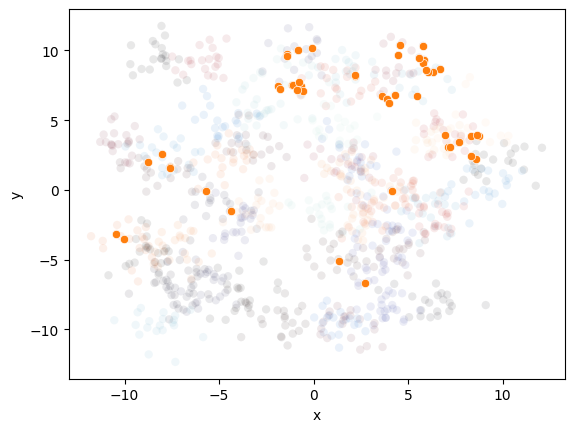

In [14]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = df, x='x', y='y', hue=target, palette=sns.color_palette("icefire", as_cmap=True), alpha=0.1, ax=ax)
ax = sns.scatterplot(data = center_cases, x='x', y='y', ax=ax)
plt.legend([],[], frameon=False)
plt.show()

# Cluster around centroids - using influential cases

Use the influential cases of each centroid to cluster the data. More specifically, tag the influential cases as the same cluster as the centroid.

Note: most similar cases is an alternative method to cluster data points. 

In [15]:
# Get the influential cases and most similar cases for each of the centroids
num_similar_cases = 5
results = t.react(case_indices=centers[[".session", ".session_training_index"]].values,
                  leave_case_out=True,
                  preserve_feature_values=context_features, action_features=[action_features], 
                  details={'most_similar_cases':True, 'num_most_similar_cases':num_similar_cases, 'influential_cases':True})

In [16]:
# Tag each influential cases with the same cluster as the centroid
centers = centers.reset_index().rename(columns={'index':'target'})
clustered_df = pd.DataFrame()

for i, cases in enumerate(results['details']['influential_cases']):
    tar = centers['target'].iloc[i]
    clustered = pd.DataFrame(cases)
    clustered['target'] = tar

    clustered_df = pd.concat([clustered_df, clustered])
    
clustered_df = clustered_df.reset_index(drop=True)

In [17]:
# Training data for evaluation purposes
df_train = t.get_cases(session=session_id, features=df.columns.tolist() + ['.session_training_index'])
df_train = df_train.join(pd.Series(target, name='target'))

df_train

,x,y,price,.session_training_index,target
0,-3.235779,-1.660880,20.497487,0,47
1,4.283446,6.814812,21.116852,1,6
2,-3.011843,-2.788841,8.100008,2,19
3,-3.863634,-1.995433,14.314644,3,16
4,1.937476,-9.014279,21.314027,4,32
...,...,...,...,...,...
995,-1.755072,7.239146,21.026818,995,2
996,-0.850211,10.007344,4.005985,996,17
997,1.363724,3.038060,19.619870,997,12
998,-8.880399,-4.024742,4.517326,998,25


In [18]:
clustered_df

,.influence_weight,x,.session,y,.session_training_index,price,target
0,0.515391,-1.106303,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,7.516132,540,21.770924,0
1,0.083729,-1.546047,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,7.526447,136,19.403382,0
2,0.054667,-0.665302,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,7.436011,377,21.449441,0
3,0.051956,-0.754514,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,7.719356,640,19.048701,0
4,0.047241,-0.858162,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,7.183051,866,20.688432,0
...,...,...,...,...,...,...,...
645,0.054959,3.691423,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,10.494341,534,6.546655,118
646,0.053316,5.528893,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,8.496590,179,21.144281,118
647,0.051599,6.061825,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,8.448215,967,21.662777,118
648,0.051413,4.082798,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,10.978343,943,5.682904,118


In [19]:
# Map each of the predicted cluster with the most commonly occurring original cluster
label_map = {}

for c in clustered_df['target'].unique():
    group_df = clustered_df[clustered_df['target'] == c]
    target_original = df_train[df_train['.session_training_index'].isin(group_df['.session_training_index'])]['target'].value_counts().idxmax()
    # print(df_train[df_train['.session_training_index'].isin(group_df['.session_training_index'])]['target'].value_counts())
    label_map[c] = target_original
    
clustered_df = clustered_df.replace({'target':label_map})

In [20]:
# Create a single table with predicted and correct target results
correct_target = []
for i in clustered_df['.session_training_index']:
    correct_t = df_train[df_train['.session_training_index'] == i]['target'].iloc[0]
    correct_target.append(correct_t)
    
clustered_df['correct_target'] = correct_target
clustered_df.head()

,.influence_weight,x,.session,y,.session_training_index,price,target,correct_target
0,0.515391,-1.106303,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,7.516132,540,21.770924,2,2
1,0.083729,-1.546047,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,7.526447,136,19.403382,2,2
2,0.054667,-0.665302,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,7.436011,377,21.449441,2,2
3,0.051956,-0.754514,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,7.719356,640,19.048701,2,2
4,0.047241,-0.858162,d57a8cd2-a418-47cc-98f5-9b7ce2741cd0,7.183051,866,20.688432,2,2


In [21]:
# Accuracy evaluation
acc = round(accuracy_score(clustered_df['correct_target'], clustered_df['target']), 3)
print(f'accuracy: {acc}')

accuracy: 0.606


Two dimensional representation of the identified clusters.

/home/runner/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/runner/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/runner/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/runner/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

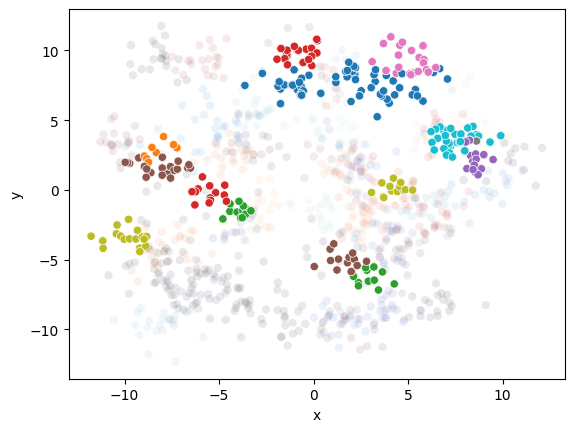

In [22]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data = df, x='x', y='y', hue=target, palette=sns.color_palette("icefire", as_cmap=True), alpha=0.1, ax=ax)
ax = sns.scatterplot(data = clustered_df, x='x', y='y', hue='target', palette=sns.color_palette("tab10", as_cmap=True), ax=ax)
plt.legend([],[], frameon=False)
plt.show()

# Impact of number of centroids

Howso Engine starts clustering with the most confident centroids (highest case_mda). Therefore, the number specified centroids can have an impact on clustering performance. 

Relatively low ratio of specified clusters vs. actual number of clusters is expected to have higher accuracy. In this example, we will demonstrate the impact of the number of cluster using 10 to 50 clusters. As a ratio of specified clusters to actual clusters, these represents a ratio of 1/5 up to 1. 

In [23]:
# Number of specified clusters
num_centers = [10, 20, 30, 40, 50]

In [24]:
# A function which finds the centroids (using case_mda), then clusters the data (using influential cases), followed by accuracy evaluation
def cluster_eval(num_centers):
    case_mdas = pd.DataFrame()
    
    results = t.react(case_indices=case_inds, preserve_feature_values=context_features,
                  action_features=[action_features], 
                  leave_case_out=True,
                  details={'case_mda':True, 'robust_influences': True})

    for c in results['details']['case_mda']:
        case_mdas = pd.concat([case_mdas, pd.DataFrame(c)])

    case_mdas = case_mdas.sort_values('mda', ascending=False).reset_index(drop=True)
    case_mdas = case_mdas[~case_mdas['.session_training_index'].duplicated()]
    centers = case_mdas[0:num_centers]

    center_cases = t.get_cases(case_indices=centers[['.session', '.session_training_index']].values)

    num_similar_cases = 5

    results = t.react(case_indices=centers[['.session', '.session_training_index']].values,
                      leave_case_out=True,
                      preserve_feature_values=context_features, action_features=[action_features], 
                      details={'most_similar_cases':True, 'num_most_similar_cases':num_similar_cases, 'influential_cases':True})

    centers = centers.reset_index().rename(columns={'index':'target'})
    clustered_df = pd.DataFrame()

    for i, cases in enumerate(results['details']['influential_cases']):
        tar = centers['target'].iloc[i]
        clustered = pd.DataFrame(cases)
        clustered['target'] = tar

        clustered_df = pd.concat([clustered_df, clustered])

    clustered_df = clustered_df.reset_index(drop=True)

    df_train = t.get_cases(session=session_id, features=df.columns.tolist() + ['.session_training_index'])
    df_train = df_train.join(pd.Series(target, name='target'))

    label_map = {}

    for c in clustered_df['target'].unique():
        group_df = clustered_df[clustered_df['target'] == c]
        target_original = df_train[df_train['.session_training_index'].isin(group_df['.session_training_index'])]['target'].value_counts().idxmax()
        # print(df_train[df_train['.session_training_index'].isin(group_df['.session_training_index'])]['target'].value_counts())
        label_map[c] = target_original

    clustered_df = clustered_df.replace({'target':label_map})

    correct_target = []
    for i in  clustered_df['.session_training_index']:
        correct_t = df_train[df_train['.session_training_index'] == i]['target'].iloc[0]
        correct_target.append(correct_t)

    clustered_df['correct_target'] = correct_target

    clustered_df.head()

    return(accuracy_score(clustered_df['correct_target'], clustered_df['target']))

In [25]:
# Get the accuracy results for each of specified number of clusters
acc = []
for n in num_centers:
    acc.append(cluster_eval(n))

Visualize the accuracy vs. number of specified centroid results

/home/runner/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/runner/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


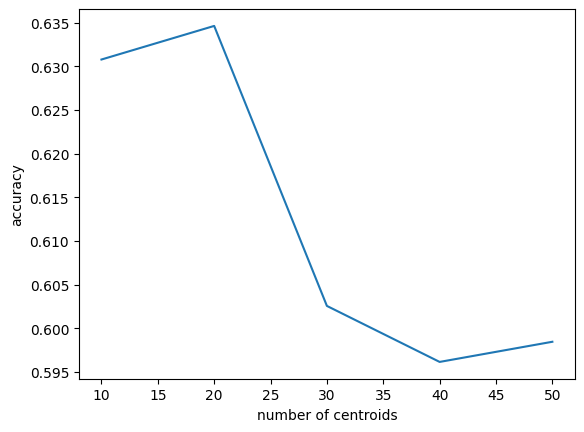

In [26]:
ax = sns.lineplot(x=num_centers, y=acc)
ax.set(xlabel='number of centroids', ylabel='accuracy')
plt.show()